In [1]:
import os
import re
from datetime import timedelta
from time import time

import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
import spacy
import warnings
warnings.filterwarnings('ignore')
from spacy import displacy
nlp = spacy.load("en_ner_bionlp13cg_md")

sns.set(style="darkgrid")

data_analysis_path = '../results/data_analysis/'

In [2]:
df = pd.read_excel('../data/Questions.xlsx')
type_to_category = {'summary': 0, 'list': 1, 'yesno': 2, 'factoid': 3}

apply_type_to_category = lambda t: type_to_category[t]

df['category_id'] = df['Type'].apply(apply_type_to_category)

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(df['Question'], df['category_id'],
                                                                                 df.index,
                                                                                 test_size=0.2, random_state=0)

In [3]:
X_train.shape, X_test.shape

((1800,), (451,))

In [10]:
def display_NER(s):
    doc = nlp(s)
    displacy.render(doc, style="ent",jupyter=True)

    
for s in X_train[6:10]:
    display_NER(s)

In [27]:
from collections import Counter

def plot_countplot(dataframe, target_column, dataset_name):
    number_of_classes = len(Counter(dataframe[target_column]))
    x_size = number_of_classes + 1
    y_size = 4
    plt.figure(figsize=(x_size, y_size))
    sns.countplot(x=target_column, data=dataframe)
    plt.savefig(data_analysis_path + 'distribution_' + dataset_name, bbox_inches='tight', dpi=200)
    plt.show()

In [11]:
whole_quora = pd.read_csv('../data/whole_quora.csv', index_col=0)
whole_quora.isnull().sum()
whole_quora= whole_quora.dropna()

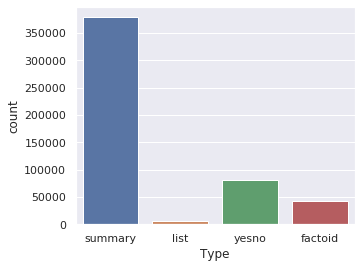

In [28]:
plot_countplot(whole_quora,'Type','whole_quora')

In [17]:
whole_quora.shape

(509089, 4)

In [18]:
filtered_quora = pd.read_csv('../data/filtered_quora.csv', index_col=0)
filtered_quora.shape

(176325, 4)

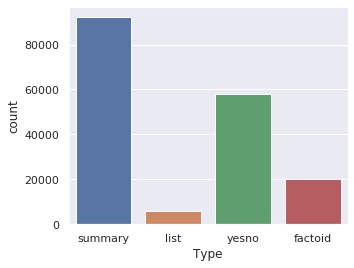

In [29]:
plot_countplot(filtered_quora,'Type','filtered_quora')

In [7]:
def parse_line(line):
    splitted = line.strip().split()
    class_name = splitted[0]
    class_f_score = splitted[3]
    return class_name, class_f_score
    
def parse_from_model_string(model_results):
    splitted = model_results.split('\n')
    # print(model_results)
    model_name = splitted[0]
    f_scores = {}
    for indx in range(3,7):
        name, f_score = parse_line(splitted[indx]) 
        f_scores[name] =f_score 
    model_training_time = splitted[-1].split()[-1]
    model_accuracy = splitted[-5].split()[-2]
    summary = {'Model':model_name,'Training Time:': model_training_time,'Accuracy': model_accuracy, 'Scores:': f_scores}
#     print(summary)
    return [model_name, model_training_time, model_accuracy, list(f_scores.values())]
    

with open('../results/t2_experiments/whole_quora_preprocessing.txt', 'r') as f:
    st = f.read()
    results_by_model = st.strip().split('--------------------------------------------------------------------------------')
    model_names = []
    model_times = []
    model_accuracies = []
    model_f_scores = []
    for model in results_by_model[:-1]:
        model_name, model_training_time, model_accuracy, f_scores = parse_from_model_string(model.strip())
        model_names.append(model_name)
        model_times.append(model_training_time)
        model_accuracies.append(model_accuracy)
        model_f_scores.append(f_scores)
    results = pd.DataFrame(index=['summary F-score','list F-score','yesno F-score','factoid F-score','Accuracy', 'Training Time'], columns=model_names)
results.loc['Accuracy',:] = model_accuracies
results.loc['Training Time',:] = model_times

for i,col in enumerate(results.columns):
    results.loc[['summary F-score','list F-score','yesno F-score','factoid F-score'],col] =  model_f_scores[i]
results    

,Random Forest,LinearSVC,Multinomial,LogisticRegression,Voting Classifier,MLP default
summary F-score,0.68,0.75,0.56,0.75,0.75,0.72
list F-score,0.65,0.65,0.31,0.66,0.66,0.68
yesno F-score,0.92,0.93,0.93,0.92,0.93,0.94
factoid F-score,0.67,0.74,0.43,0.74,0.74,0.70
Accuracy,0.75,0.78,0.61,0.78,0.79,0.77
Training Time,0:06:03.127330,0:00:35.049026,0:00:00.718535,0:00:14.469564,0:11:56.382617,0:13:09.993350


In [8]:
print(results.to_latex())

\begin{tabular}{lllllll}
\toprule
{} &   Random Forest &       LinearSVC &     Multinomial & LogisticRegression & Voting Classifier &     MLP default \\
\midrule
summary F-score &            0.68 &            0.75 &            0.56 &               0.75 &              0.75 &            0.72 \\
list F-score    &            0.65 &            0.65 &            0.31 &               0.66 &              0.66 &            0.68 \\
yesno F-score   &            0.92 &            0.93 &            0.93 &               0.92 &              0.93 &            0.94 \\
factoid F-score &            0.67 &            0.74 &            0.43 &               0.74 &              0.74 &            0.70 \\
Accuracy        &            0.75 &            0.78 &            0.61 &               0.78 &              0.79 &            0.77 \\
Training Time   &  0:06:03.127330 &  0:00:35.049026 &  0:00:00.718535 &     0:00:14.469564 &    0:11:56.382617 &  0:13:09.993350 \\
\bottomrule
\end{tabular}

